# Análisis de Componentes Principales

#### _3.1 Estudie si es posible hacer transformaciones en las variables categóricas para incluirlas en el PCA, ¿valdrá la pena?_

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.pipeline import make_pipeline
import numpy as np

In [87]:
# Cargar los datos
file_path = "movies.csv"  # Asegúrate de cambiar esto por la ruta correcta si ejecutas localmente
df = pd.read_csv(file_path, encoding="ISO-8859-1")

In [88]:
# Variables categóricas
categorical_columns = ['homePage', 'video', 'director', 'originalTitle', 'title', 'originalLanguage',
                       'genres', 'actors', 'actorsCharacter', 'productionCompanyCountry',
                       'productionCountry', 'productionCompany']

# Contar cuántas categorías únicas tiene cada variable categórica después de separar por '|'
categories_count = {}
for col in categorical_columns:
    unique_values = set()
    df[col].dropna().apply(lambda x: unique_values.update(x.split('|')) if '|' in str(x) else unique_values.add(x))
    categories_count[col] = len(unique_values)

# Mostrar los resultados en una tabla
df_categories = pd.DataFrame.from_dict(categories_count, orient='index', columns=['Unique Categories'])
df_categories = df_categories.sort_values(by='Unique Categories', ascending=False)
print("Cantidad de categorías únicas por variable categórica:")
print(df_categories)

Cantidad de categorías únicas por variable categórica:
                          Unique Categories
actorsCharacter                      164023
actors                               132626
productionCompany                     10142
originalTitle                          9761
title                                  9697
director                               6008
homePage                               4125
productionCountry                       111
productionCompanyCountry                 86
originalLanguage                         40
genres                                   19
video                                     2


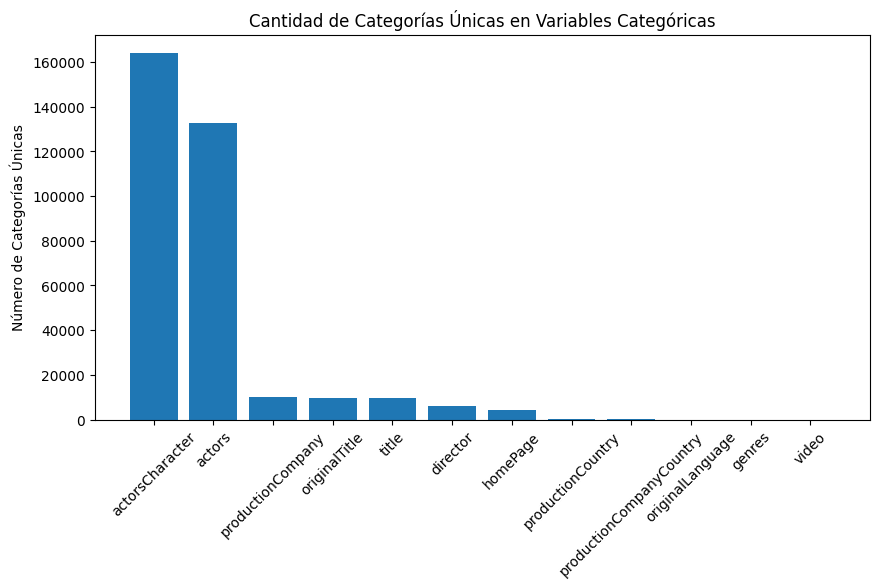

In [89]:
# Graficar
plt.figure(figsize=(10, 5))
plt.bar(df_categories.index, df_categories['Unique Categories'])
plt.xticks(rotation=45)
plt.ylabel("Número de Categorías Únicas")
plt.title("Cantidad de Categorías Únicas en Variables Categóricas")
plt.show()

In [90]:
# Aplicar One-Hot Encoding a una muestra reducida para demostrar expansión
sample_size = 500  # Reducimos el tamaño para evitar alta dimensionalidad
df_sample = df[categorical_columns].sample(sample_size, random_state=42)

def one_hot_encode_column(column):
    """Aplica One-Hot Encoding a una columna con valores separados por '|' correctamente"""
    # Expandir cada categoría en columnas separadas
    expanded_series = df_sample[column].fillna('').astype(str).str.get_dummies(sep='|')
    return expanded_series.shape[1]  # Número de columnas creadas

# Evaluar la expansión de dimensiones
ohe_expansion = {col: one_hot_encode_column(col) for col in categorical_columns}
df_ohe_expansion = pd.DataFrame.from_dict(ohe_expansion, orient='index', columns=['New Columns After OHE'])

print("Número de columnas nuevas creadas tras aplicar One-Hot Encoding:")
print(df_ohe_expansion)

Número de columnas nuevas creadas tras aplicar One-Hot Encoding:
                          New Columns After OHE
homePage                                    207
video                                         2
director                                    537
originalTitle                               497
title                                       497
originalLanguage                             20
genres                                       19
actors                                    11509
actorsCharacter                           11003
productionCompanyCountry                     44
productionCountry                            44
productionCompany                          1001


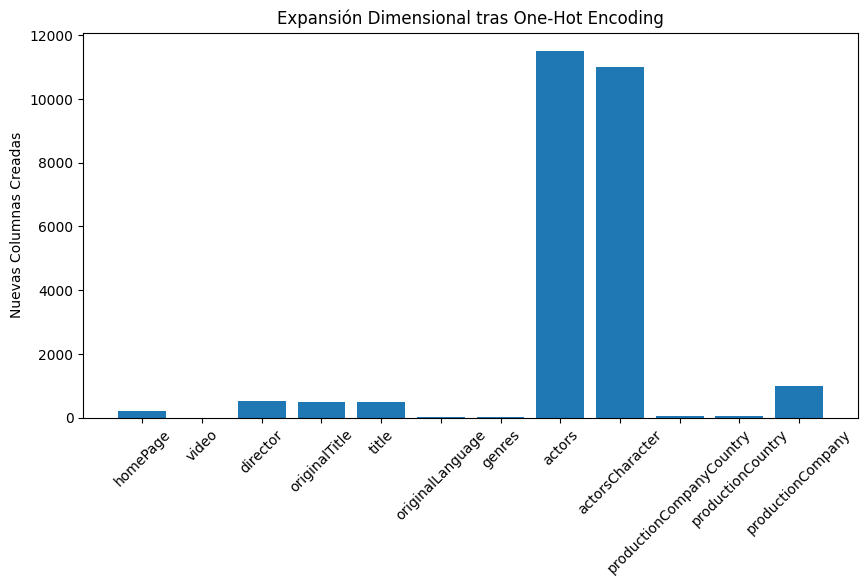

In [91]:
# Graficar expansión dimensional
plt.figure(figsize=(10, 5))
plt.bar(df_ohe_expansion.index, df_ohe_expansion['New Columns After OHE'])
plt.xticks(rotation=45)
plt.ylabel("Nuevas Columnas Creadas")
plt.title("Expansión Dimensional tras One-Hot Encoding")
plt.show()

In [92]:
# Determinar variables viables y no viables dinámicamente
threshold = 100  # Definir un umbral para considerar una variable como no viable
viable_variables = list(df_ohe_expansion[df_ohe_expansion['New Columns After OHE'] <= threshold].index)
non_viable_variables = list(df_ohe_expansion[df_ohe_expansion['New Columns After OHE'] > threshold].index)

print("\nVariables Viables para PCA:", viable_variables)
print("Variables NO Viables para PCA:", non_viable_variables)



Variables Viables para PCA: ['video', 'originalLanguage', 'genres', 'productionCompanyCountry', 'productionCountry']
Variables NO Viables para PCA: ['homePage', 'director', 'originalTitle', 'title', 'actors', 'actorsCharacter', 'productionCompany']


<small>

### **Conclusión: ¿Por qué es mejor trabajar solo con las variables numéricas en PCA?**

Después de analizar las variables categóricas y determinar cuáles son viables y no viables para PCA, la mejor opción es **trabajar solo con las variables numéricas**. Aquí está el **razonamiento técnico y práctico** que respalda esta decisión:

---

### **1. Evitar la Explosión Dimensional**
- Como vimos en el análisis, aplicar **One-Hot Encoding** a ciertas variables categóricas (como `actors`, `genres`, `productionCompany`) genera **cientos o miles de nuevas columnas**.
- PCA busca **reducir la dimensionalidad**, pero si aumentamos artificialmente la cantidad de variables, estaríamos **complicando el modelo en lugar de simplificarlo**.

✅ **Las variables numéricas ya tienen una estructura manejable para PCA sin necesidad de expansión.**

---

### **2. PCA se basa en Variabilidad Numérica**
- PCA funciona encontrando direcciones en los datos donde hay **mayor variabilidad**.
- **Variables categóricas transformadas con One-Hot Encoding solo generan 0 y 1**, lo que:
  - **No aporta una variabilidad continua.**
  - **Puede sesgar el PCA** porque ciertas categorías pueden dominar artificialmente la transformación.

✅ **Las variables numéricas tienen rangos de valores reales y continuos, lo que las hace más adecuadas para PCA.**

---

### **3. Variables Numéricas ya Capturan Información de las Categóricas**
- Muchas variables categóricas ya están **resumidas en variables numéricas**, por ejemplo:
  - `genresAmount` → Resume cuántos géneros tiene una película.
  - `actorsAmount` → Indica cuántos actores tiene una película.
  - `productionCoAmount` → Mide cuántas compañías produjeron la película.
  - `actorsPopularity` → Puede transformarse en un promedio de popularidad de actores.

✅ **Estas variables ya sintetizan información categórica sin necesidad de expansión.**

---

### **4. Interpretabilidad y Eficiencia**
- Un PCA con demasiadas variables **complica la interpretación**.
- Si incluimos **variables categóricas mal transformadas**, los componentes principales pueden ser difíciles de entender.
- **El modelo será más eficiente si se entrena solo con variables numéricas**, ya que:
  - Se reducen los cálculos innecesarios.
  - Se obtiene una mejor relación señal/ruido.

✅ **Usar solo variables numéricas permite un PCA más claro, eficiente e interpretable.**

---

### **Conclusión Final**
Dado que:
- **One-Hot Encoding genera un aumento drástico en la dimensionalidad**.
- **Las variables categóricas transformadas no aportan una variabilidad útil para PCA**.
- **Ya tenemos variables numéricas que resumen información categórica**.
- **Un PCA con variables numéricas será más eficiente y fácil de interpretar**.

➡ **Es mejor aplicar PCA solo sobre las variables numéricas.** 🚀

</small>